# Modèle stochastique pour l'analyse d'image - MVA - S2
## Projet final - 2019 / 2020
### Maximum likelihood estimation of regularisation parameters in high-dimensional inverse problems: an empirical Bayesian approach
#### Antoine Grosnit

In [2]:
import numpy as np
import seaborn as sns
import scipy
from scipy.stats import norm
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('ggplot')

import pywt

### We propose an implementation of the experiment presented in   Section   5.1: denoising with synthetic images

For the problem under study, we have: $y\sim \mathcal{N}(\Psi x, \sigma^2)$ so
$$f_y(x) = \frac{\lVert y - \Psi x\rVert^2}{2 \sigma^2}$$
$$\nabla_x f_y(x) = \frac{1}{\sigma^2} \Psi^\top (\Psi x - y), \quad L_y =  \frac{\lVert \Psi^\top \Psi \rVert_\text{op}}{\sigma^2}$$
$$g(x) = \lVert x \rVert_1, \quad \operatorname{prox}^\lambda_g(x) = \operatorname{sgn}(x) \cdot \max(|x| - \lambda, 0)$$

#### We first compute operator $\Psi$ associated to the $4$-level reverse Haar wavelet transform.

In [3]:
def generate_psi(y_size=256, level=4):
    x_size = y_size >> level
    psi = np.zeros((y_size**2, x_size**2))
    coefs = []
    coefs.append(np.zeros((x_size, x_size)))
    for i in range(level):
        coefs.append(tuple(np.zeros((3, x_size << i, x_size << i))))
    for i in tqdm(range(x_size)):
        for j in range(x_size):
            coefs[0][i, j] = 1
            psi[:, i * x_size + j] = pywt.waverec2(coefs, 'haar').flatten()
            coefs[0][i, j] = 0
    return psi

In [4]:
psi = generate_psi()

100%|██████████| 16/16 [00:00<00:00, 31.73it/s]


In [9]:
def get_y(x, psi, sigma):
    y_shape0 = int(np.sqrt(psi.shape[0]))
    mu_y = (psi @ x.flatten()).reshape(y_shape0, y_shape0)
    noise_y = sigma * np.random.normal(size=(y_shape0, y_shape0))
    y = mu_y + noise_y
    return y, SNR(mu_y, y)

In [10]:
def get_x(size=16):
    return np.random.laplace(size=(size, size))

### Select noise level $\sigma$

In [11]:
# Signal-to-noise ratio
def SNR(x_true, x):
    return 20 * np.log10(scipy.linalg.norm(x_true) / scipy.linalg.norm(x_true - x))

In [13]:
sigmas = np.logspace(-4, -1, 40) # considered sigma
snrs = []
for sig in tqdm(sigmas):
    snr = 0
    for j in range(20):
        snr += get_y(get_x(), psi, sig)[1]
    snrs.append(s / 10)

100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


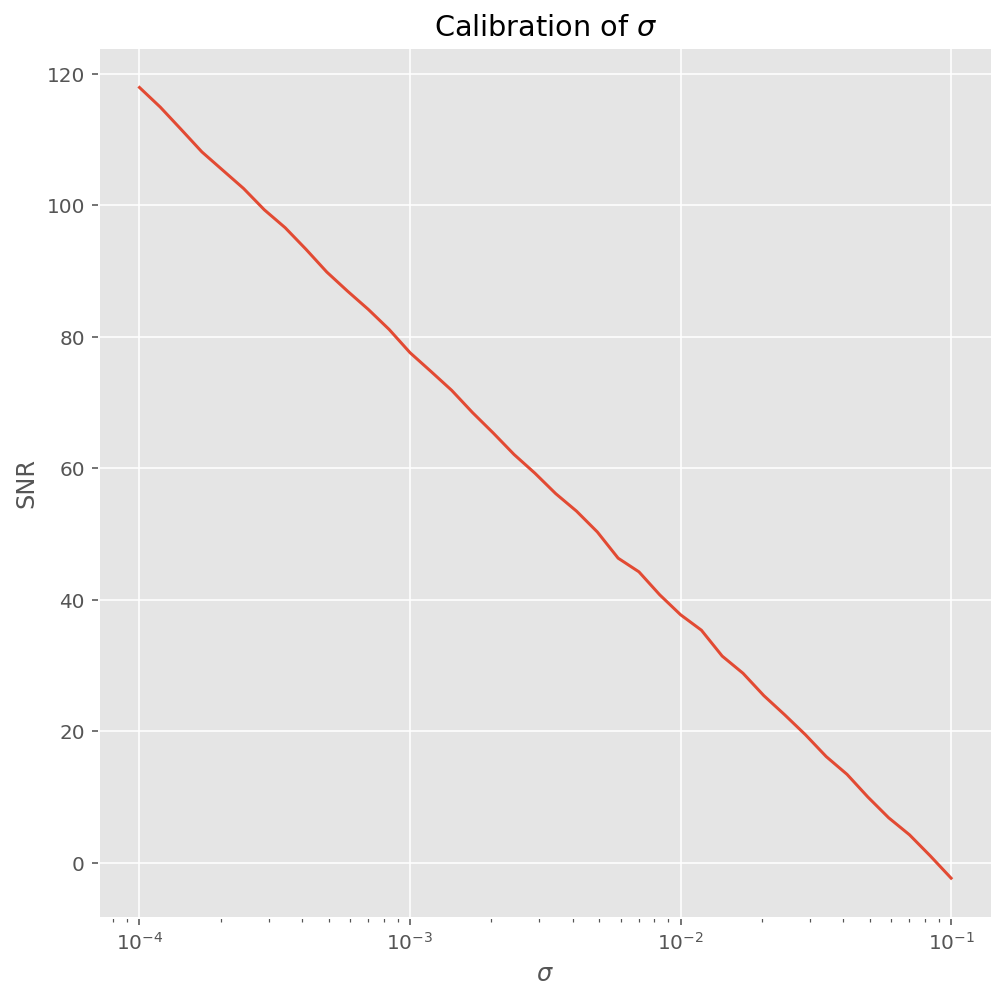

In [15]:
plt.figure(figsize=(8, 8))
plt.plot(sigmas, snrs)
plt.xscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel("SNR")
plt.title(r"Calibration of $\sigma$")
plt.show()

In [22]:
target_snr = [40, 30, 20]
snr_sig = {}
for snr in target_snr:
    snr_sig[snr] = sigmas[np.searchsorted(snrs, snr, sorter=np.arange(len(snrs)-1, -1, -1))]


for snr in snr_sig:
    print(f"For SNR = {snr}, set 𝜎 = {snr_sig[snr]:g}")

For SNR = 40, set 𝜎 = 0.00119378
For SNR = 30, set 𝜎 = 0.000701704
For SNR = 20, set 𝜎 = 0.000412463


### MYULA sampling

$$\Psi^\top \Psi = I, \quad L_y = \frac{1}{\sigma^2}$$

$$X_{k+1}=X_{k}-\gamma \nabla_{x} f_{y}\left(X_{k}\right)-\gamma\left\{X_{k}-\operatorname{prox}_{\theta^{\top} g}^{\lambda}\left(X_{k}\right)\right\} / \lambda+\sqrt{2 \gamma} Z_{k+1}$$

In [23]:
class MYULA(object):
    
    def __init__(self, x0, y, gamma, lamb, grad_f, prox_g):
        self.gamma = gamma
        self.lamb = lamb
        self.grad_f = grad_f
        self.prox_g = prox_g
        self.beta = beta
        self.x = x0.copy()
        self.y = y.copy()
        
    def sample(self, theta):
        self.x = self.x - self.gamma * self.grad_f(self.x, self.y) - self.gamma * (self.x - self.prox_g(self.x, self.lamb, theta)) / self.lamb + np.sqrt(2 * self.gamma) * np.random.normal(size=self.x.shape)
        return self.x
    

In [66]:
sigma = snr_sig[20]
Ly = 1 / sigma**2
lamb = min(2, 5 / Ly)
gamma = 0.98 / (Ly + 1 / lamb)
theta_0 = 1
beta = 0.8

In [67]:
def f_y(x, y):
    return np.linalg.norm(y - psi @ x) / (2 * sigma**2)

def grad_f_y(x, y):
    return psi.T @ (psi @ x - y) / sigma**2

def g(x):
    return np.linalg.norm(x, ord=1)

def prox_g(x, lamb, theta):
    return np.sign(x) * np.maximum(np.abs(x) - lamb * theta, 0)


In [68]:
x0 = np.zeros((16, 16)).flatten()
x = get_x()
y = get_y(x, psi, sigma)[0].flatten()
myula = MYULA(x0, y, gamma, lamb, grad_f_y, prox_g)

In [69]:
theta_0 = np.random.random() * 2
n = np.arange(50)
log_prob= []
for _ in tqdm(n):
    xx = myula.sample(theta_0)
    log_prob.append(-theta_0 * g(xx) - f_y(xx, y))
clear_output()

#### Check that MCMC sampler stabilizes after few steps (as described in Appendix B.2)

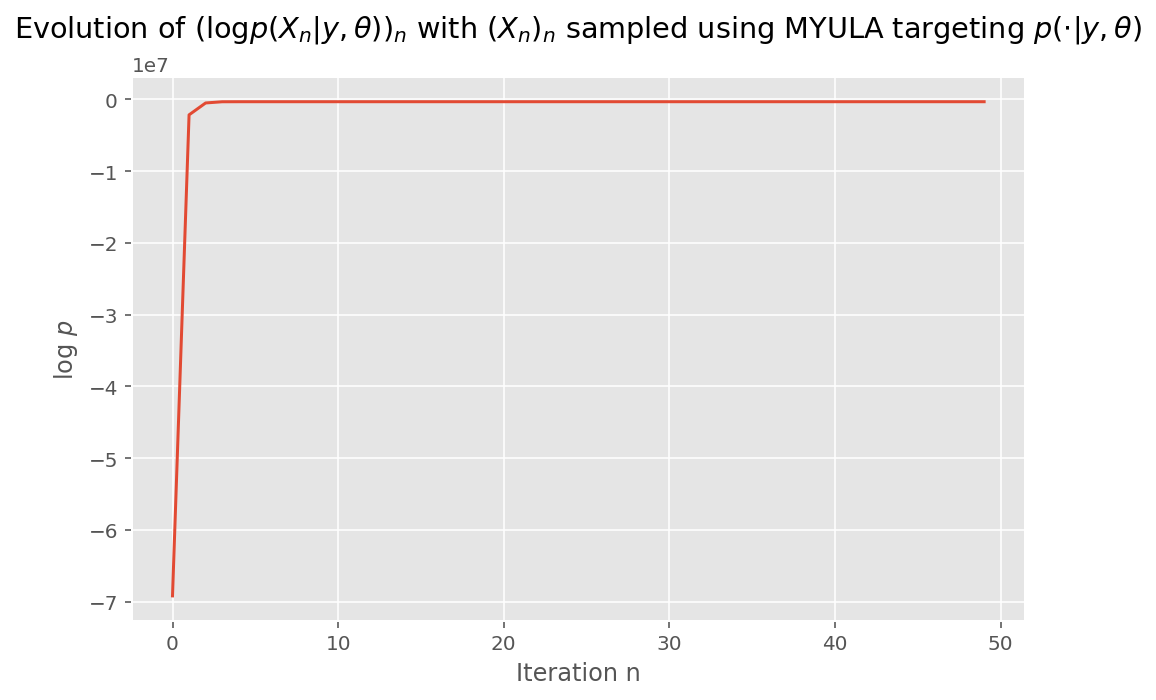

In [70]:
plt.figure(figsize=(8, 5))
log_prob[0] = -theta_0 * g(x0) - f_y(x0, y)
plt.plot(log_prob)
plt.xlabel("Iteration n")
plt.ylabel(r"$\log \ p$")
plt.title(r"Evolution of $(\log p(X_n|y,\theta))_n$ with $(X_n)_n$ sampled using MYULA targeting $p(\cdot|y,\theta)$", pad=20)
plt.show()

### SAPG

In [71]:
class SAPG(object):
    
    def __init__(self, x0, y, theta_0, gamma, lamb, grad_f, prox_g, beta):
        self.myula = MYULA(x0, y, gamma, lamb, grad_f, prox_g)
        self.theta = theta_0
        self.thetas = [self.theta]
        self.d = x0.size
        self.beta = beta
        self.n = 0
        self.x = x0.copy()
    
    @property
    def delta(self):
        return 1. / ((self.n + 1)**self.beta * self.d)
    
    def step(self):
        self.x = self.myula.sample(self.theta)
        self.theta = max(0.01, self.theta + self.delta * (self.d / self.theta - g(self.x)))
        self.thetas.append(self.theta)

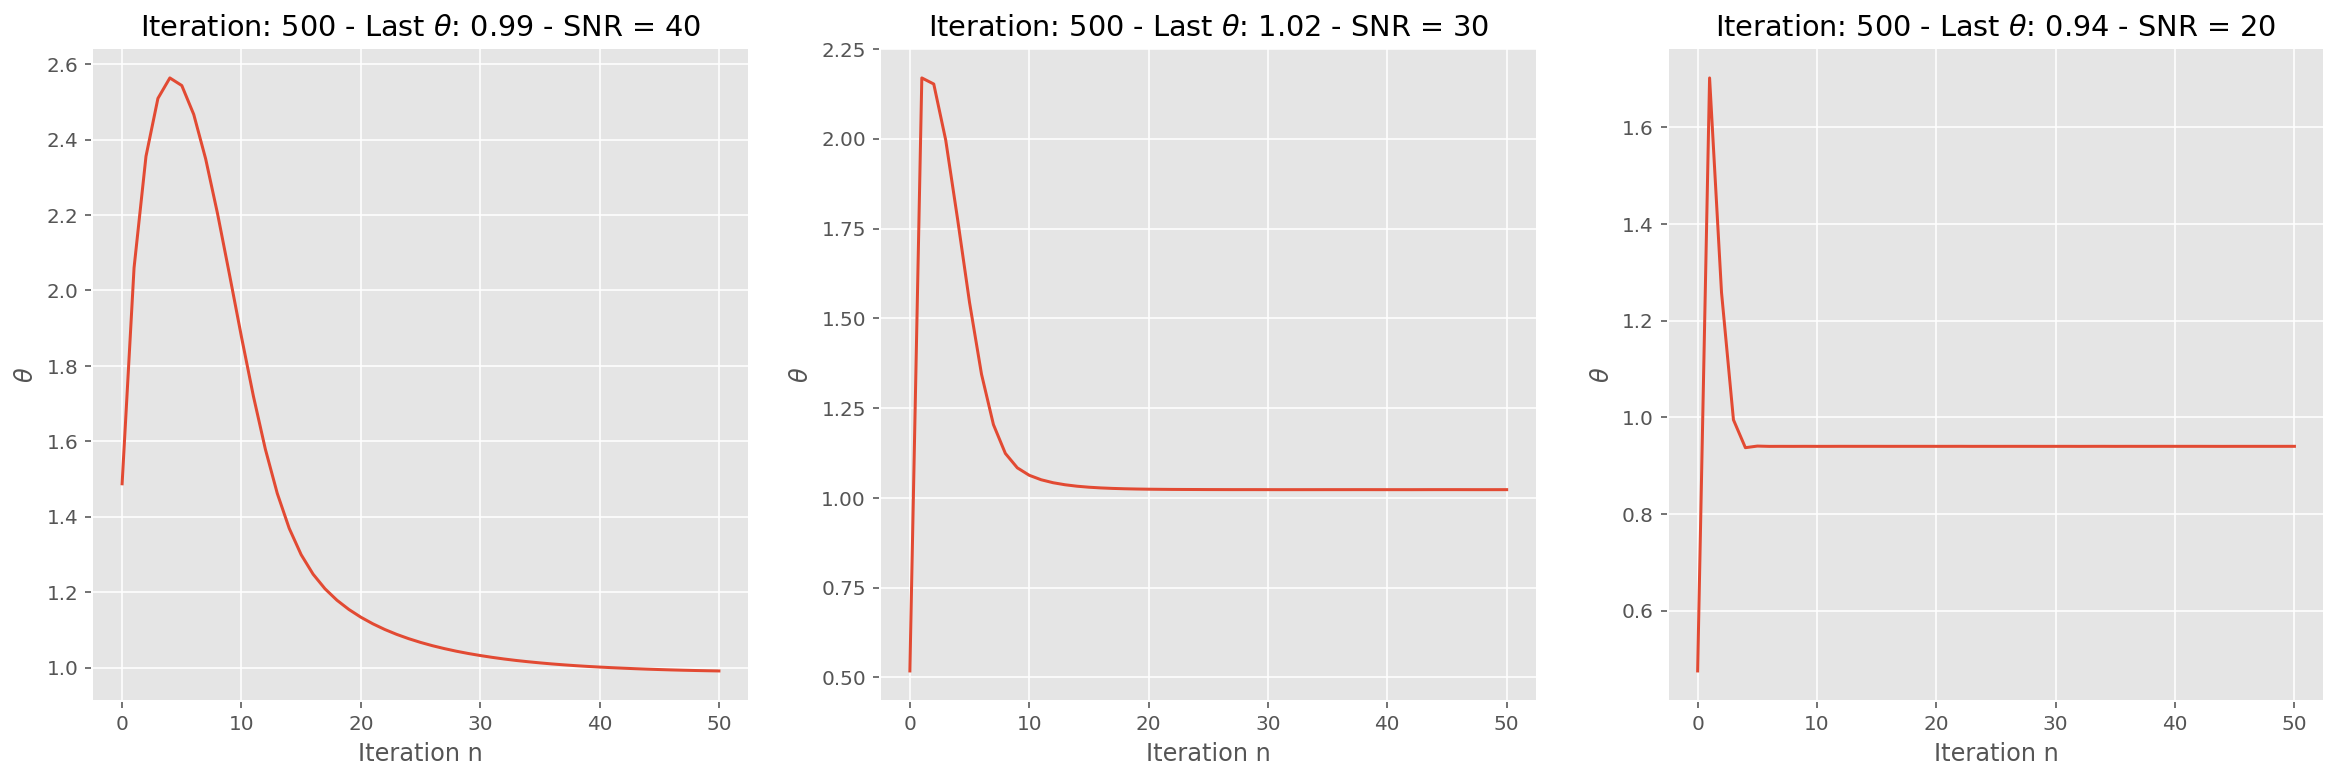

In [72]:
thetas = []
nb_ax = len(snr_sig)
sapg = {}
thetas = {snr: [] for snr in snr_sig}
for j in range(1, 501):
    for snr in snr_sig.keys():
        sigma = snr_sig[snr]
        x = get_x(16).flatten()
        y = get_y(x, psi, sigma)[0].flatten()
        x0 = np.zeros(x.shape)
        sapg[snr] = SAPG(x0, y, 0.1 +  2 * np.random.random(), gamma, lamb, grad_f_y, prox_g, beta)
        for n in range(50):
            sapg[snr].step()
        thetas[snr].append(sapg[snr].thetas[-1])
    if j % 10 == 0:
        clear_output()
        plt.figure(figsize=(20, 6))
        for k, snr in enumerate(snr_sig.keys()):
            plt.subplot(1, nb_ax, k + 1)
            plt.plot(sapg[snr].thetas)
            plt.xlabel('Iteration n')
            plt.ylabel(r'$\theta$')
            plt.title(fr'Iteration: {j} - Last $\theta$: {thetas[snr][-1]:.2f} - SNR = {snr}')
        plt.show()

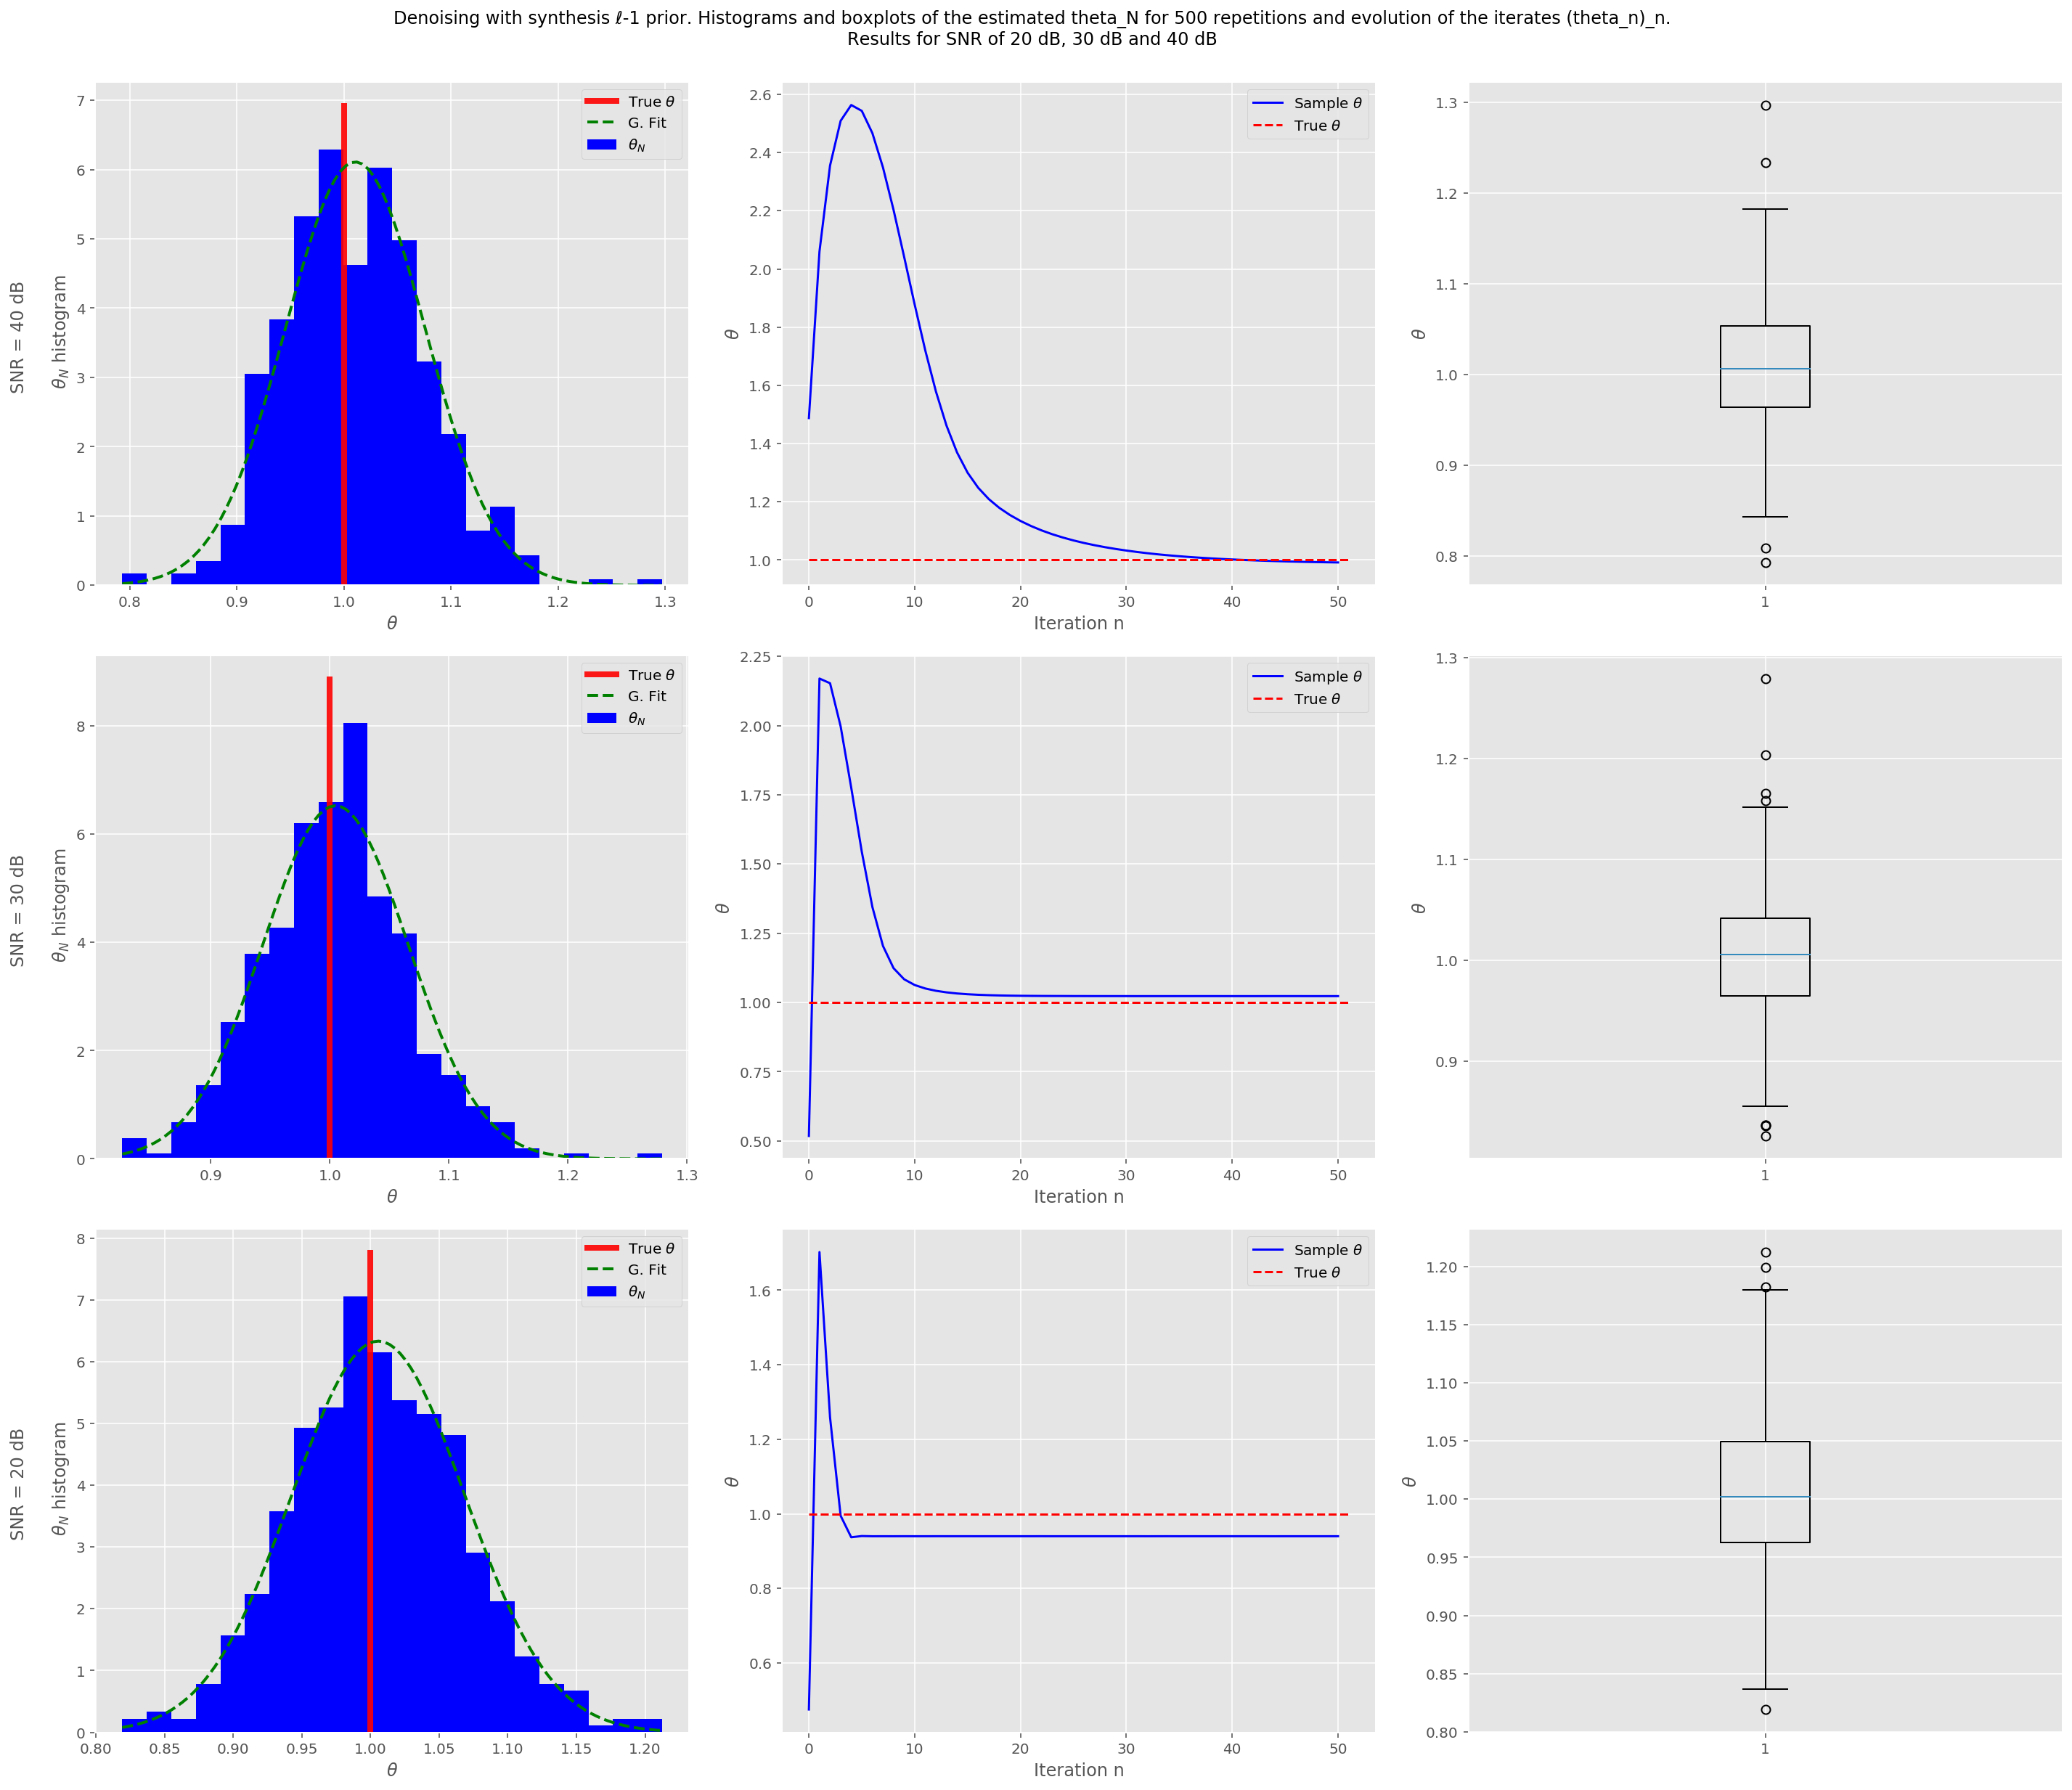

In [73]:
nb_ax = len(snr_sig.keys())

fig, axes = plt.subplots(nb_ax, 3, figsize=(20, 6 * nb_ax))

def plot_res(axes, thetas, sapg):
    h = axes[0].hist(thetas, int(np.sqrt(len(thetas))), density=True, label=r'$\theta_N$', color='b')
    axes[0].set_xlabel(r'$\theta$')
    axes[0].plot([1, 1], [0, 1.1 * max(h[0])], linewidth=4, alpha=0.9, label=r'True $\theta$', color='r')
    mu, sig = norm.fit(thetas)
    bins = np.linspace(min(thetas), max(thetas), 100)
    axes[0].plot(bins, norm.pdf(bins, loc=mu, scale=sig), color='g', linestyle='--', linewidth=2, label='G. Fit')
    axes[0].legend()

    axes[1].plot(sapg.thetas, label=r'Sample $\theta$', color='b')
    axes[1].plot([0, len(sapg.thetas)], [1, 1], linestyle='--', color='r', label=r'True $\theta$')
    axes[1].legend()
    axes[1].set_xlabel('Iteration n')
    axes[1].set_ylabel(r'$\theta$')

    axes[2].boxplot(thetas)
    axes[2].set_ylabel(r'$\theta$')


for k, snr in enumerate(snr_sig.keys()):
    plot_res(axes[k], thetas[snr], sapg[snr])
    axes[k][0].set_ylabel(f'SNR = {snr} dB \n\n ' + r'$\theta_N$ histogram', labelpad=3)

fig.suptitle("Denoising with synthesis ℓ-1 prior. Histograms and boxplots of the estimated theta_N for 500 repetitions and evolution of the iterates (theta_n)_n.\nResults for SNR of 20 dB, 30 dB and 40 dB")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We notice that we get results globally consistant with what was presented in the article, histrogram of $\theta$ is centered at the true value $1$, though with a larger variance than in the article. This may be due to a poorer choice of hyperparameters ($\lambda$, $\alpha$, $\gamma$).